<a href="https://colab.research.google.com/github/giabao804/NLP_VIN/blob/main/NLP_Th%E1%BB%B1c_h%C3%A0nh_tr%C3%AAn_l%E1%BB%9Bp_10_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bài thực hành bài 12**: Ứng dụng mô hình sequence2sequence cho bài toán dịch máy (machine translation)

Tổng quan: Ở bài tập này chúng ta sẽ lần lượt thực hành các bước để xây dựng một hệ thống học máy cho bài toán dịch máy dựa vào mạng seq2seq: tải và tiền xử lý dữ liệu song ngữ, tạo dữ liệu huấn luyện, xây dựng mô hình seq2seq với attention, hiển thị dữ liệu attention và dịch câu mới trên dữ liệu thực tế. Bài tập yêu cầu các kiến thức về lập trình Python với các thư viện: keras, numpy.

**1. Tải và tiền xử lý dữ liệu**

Nội dung chính:
1.   Tải dữ liệu song ngữ
2.   Xóa các kí tự đặc biệt trong câu
3.   Tách từ (word tokenizer)
4.   Tạo từ điển
5.   Thêm các token đặc biệt vào câu như : start, end, pad





- Import các thư viện cần thiết

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tuannguyenvananh/iwslt15-englishvietnamese")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/tuannguyenvananh/iwslt15-englishvietnamese/versions/1


- Dowload dataset

Trong bài thực hành này chúng ra sẽ sử dụng bộ song ngữ Vietnamese - English gồm 133k cặp câu song ngữ

In [25]:

OUT_DIR = "/content/data_iwslt15/IWSLT'15 en-vi/"
!mkdir $OUT_DIR
# SITE_PREFIX="https://nlp.stanford.edu/projects/nmt/data"
# # Download iwslt15 small dataset from standford website.
# print ("Download training dataset train.en and train.vi.")
# !curl -o "$OUT_DIR/train.en" "$SITE_PREFIX/iwslt15.en-vi/train.en"
# !curl -o "$OUT_DIR/train.vi" "$SITE_PREFIX/iwslt15.en-vi/train.vi"

# print ("Download dev dataset tst2012.en and tst2012.vi.")
# !curl -o "$OUT_DIR/tst2012.en" "$SITE_PREFIX/iwslt15.en-vi/tst2012.en"
# !curl -o "$OUT_DIR/tst2012.vi" "$SITE_PREFIX/iwslt15.en-vi/tst2012.vi"

# print ("Download test dataset tst2013.en and tst2013.vi.")
# !curl -o "$OUT_DIR/tst2013.en" "$SITE_PREFIX/iwslt15.en-vi/tst2013.en"
# !curl -o "$OUT_DIR/tst2013.vi" "$SITE_PREFIX/iwslt15.en-vi/tst2013.vi"

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


- Viết hàm tiền xử lý dữ liệu. Hàm này xử lý dữ liệu đầu vào như xóa bỏ các kí tự đặc biệt, lowercase, ... Ngoài ra ta cũng thêm token bắt đầu và kết thúc câu.

In [26]:
def preprocess_sentence(sentence):
  sentence = "<start> "+sentence+" <end>"
  return sentence


- Load data và xem thử data

In [27]:
def load_data(source_file, target_file, number_of_examples):
  # source_data = [preprocess_sentence(source_sentence)
  #                 for source_sentence in open(source_file, "r").readlines()[:number_of_examples]]
  # target_data = [preprocess_sentence(target_sentence)
  #                 for target_sentence in open(target_file, "r").readlines()[:number_of_examples]]
  max_len = 50
  source_sents = open(source_file, "r").readlines()
  target_sents = open(target_file, "r").readlines()
  assert len(source_sents) == len(target_sents)

  source_data, target_data = [], []
  for source_sentence, target_sentence in zip(source_sents[:number_of_examples],
                                              target_sents[:number_of_examples]):
    if len(source_sentence.strip().split()) > max_len or len(target_sentence.strip().split()) > max_len:
      continue
    source_data.append(preprocess_sentence(source_sentence))
    target_data.append(preprocess_sentence(target_sentence))

  return source_data, target_data

train_src, train_trg = load_data(OUT_DIR+"/train.en.txt", OUT_DIR+"/train.vi.txt", 1000)
print(len(train_src), len(train_trg))
print(train_src[1])
print(train_trg[1])


929 929
<start> I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
 <end>
<start> Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
 <end>


- Viết hàm tách từ (tokenizer). Nhiều ngôn ngữ có thể phân tách các từ bằng dấu cách (space) như tiếng Anh, tiếng Việt, ... Nhưng 1 số ngôn ngữ không có dấu phân tách giữa các từ như tiếng Nhật, tiếng Trung Quốc. Vì vậy, ta cần có tách từ để phân tách các từ trong câu.

In [28]:
def tokenizer(sentences):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  tokenizer.fit_on_texts(sentences)

  sent_tensors = tokenizer.texts_to_sequences(sentences)


  sent_tensors = tf.keras.preprocessing.sequence.pad_sequences(sent_tensors,
                                                         padding='post')

  return sent_tensors, tokenizer

def create_data(source_path, target_path, number_of_examples):
  # creating cleaned input, output pairs
  source_data, target_data = load_data(source_path, target_path, number_of_examples)
  source_tensors, source_tokenizer = tokenizer(source_data)
  target_tensors, target_tokenizer = tokenizer(target_data)

  return source_tensors, target_tensors, source_tokenizer, target_tokenizer



- Giới hạn số dữ liệu huấn luyện. Để kiểm tra xem chương trình chạy có đúng hay không, ban đầu ta có thể chạy thử với lượng nhỏ dữ liệu

In [30]:
number_of_examples = 50000
train_src_tensors, train_tgt_tensors, train_src_tokenizer, train_tgt_tokenizer = create_data(OUT_DIR+"/train.en.txt", OUT_DIR+"/train.vi.txt", number_of_examples)
valid_src_tensors, valid_tgt_tensors, _, _ = create_data(OUT_DIR+"/tst2012.en.txt", OUT_DIR+"/tst2012.vi.txt", -1)
test_src_tensors, test_tgt_tensors, _, _ = create_data(OUT_DIR+"/tst2013.en.txt", OUT_DIR+"/tst2013.vi.txt", -1)

max_length_source, max_length_target = train_src_tensors.shape[1], train_tgt_tensors.shape[1]

print(len(train_src_tensors))
# print(train_src_tensors[0])

# View source dictionary
print(len(train_src_tokenizer.word_index))
for t in train_src_tensors[0][:5]:
  print(t, train_src_tokenizer.index_word[t])


45952
26370
1 <start>
7615 rachel
14913 pike
56 :
5 the


**2. Tạo dữ liệu huấn luyện**

Nội dung chính: Tạo dữ liệu huấn luyện theo batch

In [31]:
BUFFER_SIZE = len(train_src_tensors)
BATCH_SIZE = 64
steps_per_epoch = len(train_src_tensors)//BATCH_SIZE

vocab_src_size = len(train_src_tokenizer.word_index)+1
vocab_tgt_size = len(train_tgt_tokenizer.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((train_src_tensors, train_tgt_tensors)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 52]), TensorShape([64, 52]))

**3. Viết mô hình seq2seq với attention**

Nội dung chính : Viết Encoder, BahdanauAttention, Decoder

In [82]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_state_size, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.hidden_state_size = hidden_state_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.SimpleRNN(self.hidden_state_size,
                                     return_sequences=True,
                                     return_state=True,
                                     recurrent_initializer='glorot_uniform')


  def call(self, x, hidden):
    # YOUR CODE HERE
    x = self.embedding(x)
    # The GRU with return_sequences and return_state might return three values.
    # Adjust the unpacking accordingly
    output, state = self.rnn(x, initial_state = hidden) #Only unpack the last two values
    # YOUR CODE HERE
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.hidden_state_size))

- Tạo Encoder và test thử  Encoder đó với 1 batch dữ liệu và in ra shape của encoder output

In [83]:
embedding_dim = 512
hidden_state_size = 512


encoder = Encoder(vocab_src_size, embedding_dim, hidden_state_size, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
#

Encoder output shape: (batch size, sequence length, units) (64, 52, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)


In [64]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # Ensure that query has shape (batch_size, hidden_size)
    if len(query.shape) == 1:
        query = tf.expand_dims(query, 0)  # Add batch dimension if missing

    # Expand query to (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # Apply W1 to query and W2 to values
    W1_query = self.W1(query_with_time_axis)
    W2_values = self.W2(values)

    # Broadcast addition along the time axis
    score = self.V(tf.nn.tanh(W1_query + W2_values))

    # Compute softmax along the sequence length to get attention weights
    attention_weights = tf.nn.softmax(score, axis=1)

    # Compute the context vector as a weighted sum of values
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [65]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 52, 1)


In [84]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_state_size, batch_sz):
    super(Decoder, self).__init__()
    # YOUR CODE HERE
    self.batch_sz = batch_sz
    self.hidden_state_size = hidden_state_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.SimpleRNN(self.hidden_state_size,
                                     return_sequences=True,
                                     return_state=True,
                                     recurrent_initializer='glorot_uniform')



    self.fc = tf.keras.layers.Dense(vocab_size)
    # YOUR CODE HERE

    # used for attention
    self.attention = BahdanauAttention(self.hidden_state_size)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.rnn(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [85]:
decoder = Decoder(vocab_tgt_size, embedding_dim, hidden_state_size, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 12469)


**4. Định nghĩa hàm tối ưu (optimizer) và hàm lỗi (loss function)**

Nội dung chính: Sử dụng hàm tối ưu Adam và hàm lỗi CrossEntropy

In [86]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # YOUR CODE HERE
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # YOUR CODE HERE

  return tf.reduce_mean(loss_)

**5. Huấn luyện mô hình (Training)**

Nội dung chính: Sử dụng dữ liệu, mô hình seq2seq + attention đã build ở trên để huấn luyện mô hình.

In [87]:
@tf.function
def train_step(source, target, enc_hidden):
  loss = 0
  # YOUR CODE HERE
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(source, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([train_tgt_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, target.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(target[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(target[:, t], 1)
  # YOUR CODE HERE


  batch_loss = (loss / int(target.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


checkpoint_dir = './model_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

EPOCHS = 1

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (source, target)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(source, target, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 1 epochs
  checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))




Epoch 1 Batch 0 Loss 3.7157
Epoch 1 Batch 100 Loss 2.5290
Epoch 1 Batch 200 Loss 2.7285
Epoch 1 Batch 300 Loss 2.5458
Epoch 1 Batch 400 Loss 1.9934
Epoch 1 Batch 500 Loss 2.0336
Epoch 1 Batch 600 Loss 2.1701
Epoch 1 Batch 700 Loss 1.9004
Epoch 1 Loss 2.3825
Time taken for 1 epoch 282.44951248168945 sec



**6. Dịch (Translate)**

Nội dung chính: Sử dụng mô hình đã được huấn luyện để  dịch dữ liệu mới

In [88]:
def evaluate(source_sentence):
  attention_plot = np.zeros((max_length_target, max_length_source))

  source_sentence = preprocess_sentence(source_sentence)

  inputs = [train_src_tokenizer.word_index[i] for i in source_sentence.lower().split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_source,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  # YOUR CODE HERE
  hidden = None
  enc_out, enc_hidden = None

  dec_hidden = None
  dec_input = None

  for t in range(max_length_target):
    predictions, dec_hidden, attention_weights = None

    # storing the attention weights to plot later on
    attention_weights = None
    attention_plot[t] = None

    predicted_id = None

    result += None

  # YOUR CODE HERE


    if train_tgt_tokenizer.index_word[predicted_id] == '<end>':
      return result, source_sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, source_sentence, attention_plot

source_sentence = "How are you ?"
result, source_sentence, attention_plot = evaluate(source_sentence)
print('Input: %s' % (source_sentence))
print('Predicted translation: {}'.format(result))

TypeError: cannot unpack non-iterable NoneType object

**7. Hiển thị attention (Plot attention)**

Nội dung chính : Hiển thị attention để hiểu rõ hơn vai trò của attention trong mô hình seq2seq


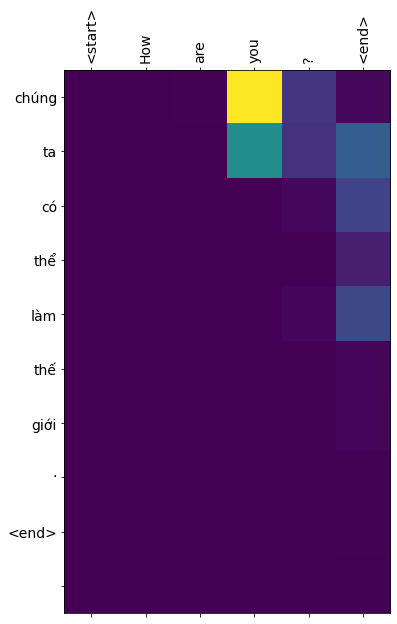

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

attention_plot = attention_plot[:len(result.split(' ')), :len(source_sentence.split(' '))]
plot_attention(attention_plot, source_sentence.split(' '), result.split(' '))

**8. Tính điểm BLEU**

BLEU là 1 độ đo rất phổ biến để đánh giá chất lượng của 1 hệ thống dịch máy. Bạn có thể download script tính multi-bleu tại github của mosesdecoder : https://github.com/moses-smt/mosesdecoder/blob/master/scripts/generic/multi-bleu.perl

Trong bài này, chúng tôi sẽ sử dụng hàm tính bleu có sẵn trong python.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


Bài tập : Hãy sử dụng BLEU để đánh giá mô hình bạn vừa huấn luyện